<pre>
Copyright 2022 Boris Shminke

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
</pre>

In this notebook we try to reproduce another axiom independence theorem (Theorem 11 from https://doi.org/10.1155/2014/854168)

In [1]:
import nest_asyncio
from isabelle_client import start_isabelle_server

nest_asyncio.apply()
# on Windows one should start Isabelle server using Cygwin
# and paste `server_info` string here
server_info, _ = start_isabelle_server()

In [2]:
%%time
# we apply the same pipeline, as can be seen in `lattice-indep.ipynb` file
from residuated_binars.constants import LATTICE, BOUNDED_LATTICE, PSEUDO_R0_ALGEBRA
from residuated_binars.use_nitpick import use_nitpick
from residuated_binars.utils import remove_dirs

remove_dirs(("task*", "hyp*"))
MAX_DIM = 10
use_nitpick(
    max_cardinality=MAX_DIM,
    independent_assumptions=PSEUDO_R0_ALGEBRA,
    additional_assumptions=LATTICE + BOUNDED_LATTICE + [
        "(inv1(inv2(C1)) = C1)", "(inv2(inv1(C1)) = C1)",
        "(inv1(inv2(C0)) = C0)", "(inv1(inv2(C0)) = C0)"
    ],
    check_subset_independence=False,
    server_info=server_info
)

CPU times: user 30.6 ms, sys: 16.2 ms, total: 46.8 ms
Wall time: 56.6 s


In [3]:
import os
from residuated_binars.parser import isabelle_response_to_algebra

structures = []
for i in range(MAX_DIM + 1):
    try:
        structures += isabelle_response_to_algebra(
            os.path.join(".", f"task{i}", "isabelle.out")
        )
    except:
        pass

In [4]:
tuple((structure.label, structure.cardinality) for structure in structures)

(('T0234_1', 2),
 ('T1234_0', 2),
 ('T0123_4', 4),
 ('T0124_3', 4),
 ('T0134_2', 4))

Interestingly, the counter-example cardinalities are no higher than 4, although in the original paper the author proposed a model of size eight (see Figure 1).

In [5]:
# Now let's double-check the counter-examples found
from residuated_binars.pseudo_r0_algebra import PseudoR0Algebra
from residuated_binars.algebraic_structure import BOT, TOP

for structure in structures:
    new_map = {symbol: symbol for symbol in structure.symbols}
    new_map.update({"C0": BOT, "C1": TOP})
    structure.remap_symbols(new_map)
    print(structure)
    try:
        PseudoR0Algebra(structure.label, structure.operations)
    except ValueError as error:
        print(f"{structure.label}: {error}")

{'imp1': [[1, 1], [1, 1]], 'imp2': [[1, 1], [1, 1]], 'inv1': [0, 1], 'inv2': [0, 1], 'join': [[0, 1], [1, 1]], 'meet': [[0, 0], [0, 1]]}
T0234_1: P2 axiom doesn't hold
{'imp1': [[1, 1], [0, 1]], 'imp2': [[1, 1], [0, 1]], 'inv1': [0, 1], 'inv2': [0, 1], 'join': [[0, 1], [1, 1]], 'meet': [[0, 0], [0, 1]]}
T1234_0: P1 axiom doesn't hold
{'imp1': [[3, 3, 3, 3], [2, 3, 1, 3], [1, 3, 3, 3], [0, 1, 2, 3]], 'imp2': [[3, 3, 3, 3], [2, 3, 1, 3], [1, 3, 3, 3], [0, 1, 2, 3]], 'inv1': [3, 2, 1, 0], 'inv2': [3, 2, 1, 0], 'join': [[0, 1, 2, 3], [1, 1, 1, 3], [2, 1, 2, 3], [3, 3, 3, 3]], 'meet': [[0, 0, 0, 0], [0, 1, 2, 1], [0, 2, 2, 2], [0, 1, 2, 3]]}
T0123_4: P5 axiom doesn't hold
{'imp1': [[3, 3, 3, 3], [2, 3, 2, 3], [1, 1, 3, 3], [0, 1, 2, 3]], 'imp2': [[3, 3, 3, 3], [2, 3, 2, 3], [1, 1, 3, 3], [0, 1, 2, 3]], 'inv1': [3, 2, 1, 0], 'inv2': [3, 2, 1, 0], 'join': [[0, 1, 2, 3], [1, 1, 2, 3], [2, 2, 2, 3], [3, 3, 3, 3]], 'meet': [[0, 0, 0, 0], [0, 1, 1, 1], [0, 1, 2, 2], [0, 1, 2, 3]]}
T0124_3: P4 axi

In the original paper, `inv1` and `inv2`, as well as `imp1` and `imp2` were often different. As we can see now, that was not at all necessary:

In [6]:
for structure in structures:
    assert structure.operations["inv1"] == structure.operations["inv2"]
    assert structure.operations["imp1"] == structure.operations["imp2"]

Also, lattice reducts of models with the same dimensions are isomorphic

In [7]:
structures[2].remap_symbols({BOT: BOT, TOP: TOP, "C2": "C3", "C3": "C2"})
assert structures[0].operations["meet"] == structures[1].operations["meet"]
assert structures[0].operations["join"] == structures[1].operations["join"]
for i in (3, 4):
    assert structures[2].operations["meet"] == structures[i].operations["meet"]
    assert structures[2].operations["join"] == structures[i].operations["join"]

Moreover, even for counter-examples of size four, lattice reducts expresses nothing more complex than linear order (compare to Figure 1).

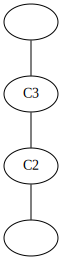

In [8]:
from residuated_binars.bounded_lattice import BoundedLattice

BoundedLattice("example", structures[2].operations).graphviz_repr